## Семинар 10: "Генерация текстов"

ФИО: Косарев Евгений Александрович

In [0]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [203]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2020-04-29 15:03:04--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt.4’

author-quote.txt.4  100%[===================>]   5.35M  --.-KB/s    in 0.05s   

2020-04-29 15:03:04 (99.8 MB/s) - ‘author-quote.txt.4’ saved [5615127/5615127]



In [0]:
lines = [
    x.split('\t')[0].strip() ##!!!!!
    for x in open('author-quote.txt').readlines()
]

In [0]:
lines = list(set(lines))

In [292]:
len(lines)

3112

In [293]:
lines[0]

'Michael Irvin'

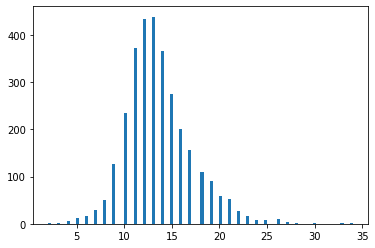

In [294]:
plt.hist(list(map(len, lines)), bins=100);

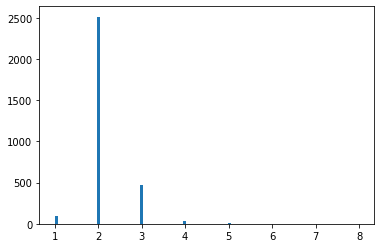

In [295]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [0]:
line = lines[0]

In [297]:
line

'Michael Irvin'

In [0]:
lines = list(
     filter(lambda x: len(x.split()) <= 50,
            lines)
 )

In [299]:
len(lines)

3112

In [300]:
np.random.seed(777)
torch.manual_seed(777)

In [0]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [0]:
class VocabForWords:
    def __init__(self, sentences):
        all_words = set()
        for line in sentences:
            all_words |= set(line.split())
        all_words = list(all_words)+['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_words)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_words)
        }
        self.size = len(all_words)

    def encode(self, line):
        return [self.char_to_id[x] for x in line.split()]
    
    def decode(self, tokens):
        out = ''
        for i in range(len(tokens) - 1):
            out += self.id_to_char[tokens[i]]
            out += ' '
        out += self.id_to_char[tokens[len(tokens) - 1]]
        return out

In [0]:
vocab = Vocabulary(lines)

In [304]:
lines[0]

'Michael Irvin'

In [305]:
len(vocab.char_to_id)

79

In [306]:
d = vocab.encode(lines[0])
d

[18, 40, 34, 39, 32, 36, 43, 0, 14, 49, 53, 40, 45]

In [307]:
vocab.decode(d)

'Michael Irvin'

In [0]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [0]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [0]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [0]:
dataset = Quotes(lines, vocab)

In [0]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=64,
    collate_fn=compose_batch)

### Часть 2: определение модели

In [0]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):    
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [0]:
oracle = Oracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)

### Часть 3: обучение модели

In [0]:
"""
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)
"""

optimizer = torch.optim.Adam(oracle.parameters())

In [0]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [0]:
losses = []

In [0]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

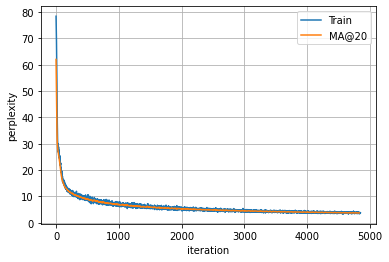

In [319]:
for epoch in range(100):
    #bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(dataloader):  
        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [322]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'Henry North Hamilton<eos>'

In [0]:
res = oracle.embedding(torch.from_numpy(np.asarray([vocab.char_to_id["D"], vocab.char_to_id["a"], vocab.char_to_id["B"]]))).detach().numpy()

In [324]:
res.shape

(3, 32)

In [0]:
res = res / np.sqrt((res**2).sum(-1))[:, np.newaxis]

In [326]:
(res @ res.T)

array([[0.9999999 , 0.03476154, 0.22607476],
       [0.03476154, 1.0000002 , 0.05773336],
       [0.22607476, 0.05773336, 1.        ]], dtype=float32)

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

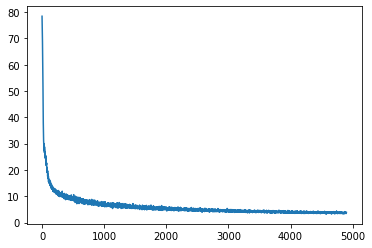

In [327]:
plt.plot(losses)

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

## 1. Oracle с LSTM

In [0]:
class LSTMOracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.LSTM(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):    
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [0]:
oracle = Oracle(vocab.size,
                embedding_size=64,
                hidden_size=128, layers=2)

## 2. Разделение на train-test

In [0]:
lines = [
    x.split('\t')[0].strip() ##!!!!!
    for x in open('author-quote.txt').readlines()
]
lines = list(set(lines))
trainlines = lines[:2 * (len(lines) // 3)]
testlines = lines[2 * (len(lines) // 3):]
vocab = Vocabulary(lines)
traindataset = Quotes(trainlines, vocab)
testdataset = Quotes(testlines, vocab)

In [0]:
traindataloader = DataLoader(
            traindataset, shuffle=True,
            batch_size=64,
            collate_fn=compose_batch)
testdataloader = DataLoader(
            testdataset, shuffle=True,
            batch_size=64,
            collate_fn=compose_batch)

## 3. Обучение + подбор параметров

In [0]:
optimizer = torch.optim.Adam(oracle.parameters())
criterion = nn.CrossEntropyLoss(reduction='none')
losses = []
test_losses = []

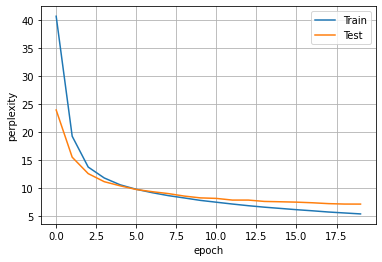

In [373]:
for epoch in range(20):
    #bar = progressbar.ProgressBar()
    cur_losses = []
    for i, (go, eos, mask, length) in enumerate(traindataloader):  
        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        cur_losses.append(np.exp(loss.item()))
    losses.append(np.mean(cur_losses))
    cur_losses = []
    for i, (go, eos, mask, length) in enumerate(testdataloader):
        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        cur_losses.append(np.exp(loss.item()))
    test_losses.append(np.mean(cur_losses))

    clear_output(True)
    plt.plot(losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('epoch')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.show()

In [374]:
test_losses[-1]

7.077896622161971

In [398]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'David Cooke<eos>'

Таким образом, увеличив размер ембеддинга и hidden_size вдвое, получили перплексию 7 (с параметрами до умолчанию было 9).

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: